# 1. Preprocessing
## Import data

In [4]:
! pip install scikeras
! pip install pandas
! pip install nltk
! pip install scikit-learn


pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.
pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.
pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.
pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.


In [1]:
import pandas as pd
df = pd.read_csv('training.300000.processed.noemoticon.csv', encoding='ISO-8859-1')

## Text clean

In [2]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liuyifan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/liuyifan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/liuyifan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))


def clean_text(text):
    # transfer to lower characters
    text = text.lower()
    
    # eliminate url link
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # eliminate special character
    text = re.sub(r'@\w+|#\w+', '', text)
    
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # eliminate stop word
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    
   
    return ' '.join(tokens)

# apply clean function to data frame
df['cleaned_text'] = df['text'].apply(clean_text)

df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh hope ok
1,"@misstoriblack cool , i have no tweet apps fo...",cool tweet apps razr
2,@TiannaChaos i know just family drama. its la...,know family drama lamehey next time u hang kim...
3,School email won't open and I have geography ...,school email wont open geography stuff revise ...
4,upper airways problem,upper airways problem


## Divide dataset into two parts, trainset and testset

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transfer original labels to 0-1 label
y = df['sentiment'].values  
y = (y == 4).astype(int) 
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], y, test_size=0.2, random_state=42)


## Tokenization, Padding

In [5]:
# Define tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Transfer to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding sequence to a constant length
X_train = pad_sequences(X_train, maxlen=50)
X_test = pad_sequences(X_test, maxlen=50)


# 2. Deep learning

## CNN
Model implement

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Dropout, Flatten, Input

# from previous block, which maximum length of sequence is 50
sequence_length = 50

# define cnn
model_1 = Sequential()

# add input layer
model_1.add(Input(shape=(sequence_length,)))

# add embedding layer, map word id to a vector
model_1.add(Embedding(input_dim=10000, output_dim=50))

# convolutional layer
model_1.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# pool layer
model_1.add(MaxPooling1D(pool_size=2))

# fc1
model_1.add(Flatten())

# Dropout layer
model_1.add(Dropout(0.5))

# fc2
model_1.add(Dense(64, activation='relu'))

# output layer
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# show model structure
model_1.summary()

model_1.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
loss, accuracy = model_1.evaluate(X_test, y_test)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 128)        │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       188,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 720,673 (2.75 MB)

 Trainable params: 720,673 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7060 - loss: 0.5474 - val_accuracy: 0.7718 - val_loss: 0.4763
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7958 - loss: 0.4403 - val_accuracy: 0.7738 - val_loss: 0.4700
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8185 - loss: 0.3988 - val_accuracy: 0.7690 - val_loss: 0.4946
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8436 - loss: 0.3524 - val_accuracy: 0.7617 - val_loss: 0.5284
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8652 - loss: 0.3078 - val_accuracy: 0.7559 - val_loss: 0.5800
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8807 - loss: 0.2745 - val_accuracy: 0.7498 - val_loss: 0.6678
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8919 - loss: 0.2496 - val_accuracy: 0.7477 - val_loss: 0.7484
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9004 -

Fine tune

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import json


# Define cnn model structure
def create_model(optimizer='adam', filters=64, kernel_size=5, dropout_rate=0.5):
    sequence_length = 50  
    model = Sequential()
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=50))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model
# Wrape Keras model for sklearn
model_1_f = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=0)

# Search list
param_dist = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__filters': [32, 64, 128],
    'model__kernel_size': [3, 5],
    'model__dropout_rate': [0.2, 0.3],
    'epochs': [5, 10, 15],
    'batch_size': [32, 64]
}

random_search = RandomizedSearchCV(estimator=model_1_f, param_distributions=param_dist, n_iter=10, cv=3)
random_search.fit(X_train,y_train)
# save best paramaters combination
best_params = random_search.best_params_
with open('best_paramscnn.json', 'w') as f:
    json.dump(best_params, f)
#    
model_1_best=random_search.best_estimator_.model_
model_1_best.save("bestcnn.h5")


/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will 

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=128, build_fn=<function create_model at 0x7fce7c740e00>, epochs=10, verbose=0),
                   param_distributions={'batch_size': [32, 64],
                                        'epochs': [5, 10, 15],
                                        'model__dropout_rate': [0.2, 0.3],
                                        'model__filters': [32, 64, 128],
                                        'model__kernel_size': [3, 5],
                                        'model__optimizer': ['adam',
                                                             'rmsprop']})

In [21]:
import json
from sklearn.metrics import accuracy_score

# 获取最佳参数
best_params = random_search.best_params_

# 将最佳参数保存为 JSON 文件
with open('best_paramscnn.json', 'w') as f:
    json.dump(best_params, f)

# 打印最佳参数
print(f"Best Parameters: {best_params}")

# 使用最佳模型对测试集进行评估
model_1_best = random_search.best_estimator_

# 评估模型并打印结果（例如使用准确率评估）
accuracy = model_1_best.score(X_test,y_test)
model_1_best=random_search.best_estimator_.model_
loss, accuracy= model_1_best.evaluate(X_test, y_test)
print(loss,accuracy)
model_1_best.save("bestcnn.h5")


Best Parameters: {'model__optimizer': 'rmsprop', 'model__kernel_size': 3, 'model__filters': 32, 'model__dropout_rate': 0.2, 'epochs': 15, 'batch_size': 32}
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7760 - loss: 0.4878


0.49118101596832275 0.777233362197876


## LSTM
model implement

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.optimizers import Adam
def create_lstm_model(optimizer='adam',output_dim=50 ,units=64,dropout_rate=0.5):
    model=Sequential()
    sequence_length=50
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=output_dim))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_2=create_lstm_model()
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()
model_2.fit(X_train,y_train,epochs=10, batch_size=128, validation_split=0.2)
loss, accuracy=model_2.evaluate(X_test,y_test)
    
    

2024-10-09 18:47:00.115403: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-09 18:47:00.115444: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-09 18:47:00.115451: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-09 18:47:00.115471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-09 18:47:00.115487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,665 (2.04 MB)

 Trainable params: 533,665 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-10-09 18:47:00.666863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7189 - loss: 0.5416 - val_accuracy: 0.7716 - val_loss: 0.4801
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.7902 - loss: 0.4475 - val_accuracy: 0.7725 - val_loss: 0.4726
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.8021 - loss: 0.4236 - val_accuracy: 0.7729 - val_loss: 0.4780
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8125 - loss: 0.4034 - val_accuracy: 0.7688 - val_loss: 0.4893
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8230 - loss: 0.3846 - val_accuracy: 0.7674 - val_loss: 0.5079
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.8354 - loss: 0.3608 - val_accuracy: 0.7660 - val_loss: 0.5312
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8457 - loss: 0.3388 - val_accuracy: 0.7597 - val_loss: 0.5736
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8561 - loss: 0.32

Fine Tune

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam
import json

def create_lstm_model(optimizer='adam',output_dim=50 ,units=64,dropout_rate=0.5):
    model=Sequential()
    sequence_length=50
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=output_dim))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Wrape Keras model for sklearn
model_2_f = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=128, verbose=0)
# Search list
param_dist = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__output_dim': [50, 100, 150,200],
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.3,0.5],
    'epochs': [5, 10, 15],
    'batch_size': [32, 64]
}
random_search = RandomizedSearchCV(estimator=model_2_f, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=2)
random_search.fit(X_train,y_train)

# save best paramaters combination
best_params = random_search.best_params_
with open('best_paramlstm.json', 'w') as f:
    json.dump(best_params, f)
#    
model_2_best=random_search.best_estimator_.model_
model_2_best.save("bestlstm.h5")

/Users/liuyifan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/liuyifan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2024-10-09 19:22:59.306833: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-09 19:22:59.306833: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-09 19:22:59.306856: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-09 19:22:59.306856: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-09 19:22:59.306862: I metal_plugin/src/device/meta

## Transformer

Implement

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding
import numpy as np

# 多头注意力机制
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        scaled_attention_logits = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits /= tf.math.sqrt(tf.cast(self.depth, tf.float32))

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return self.dense(output)

# 前馈网络
class FeedForward(Layer):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = Dense(d_ff, activation='relu')
        self.linear2 = Dense(d_model)

    def call(self, x):
        return self.linear2(self.linear1(x))

# Add & Norm 层
class AddNormalization(Layer):
    def __init__(self):
        super(AddNormalization, self).__init__()
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, x, sublayer_output):
        return self.layer_norm(x + sublayer_output)

# 编码器层
class EncoderLayer(Layer):
    def __init__(self, num_heads, d_model, d_ff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.ffn = FeedForward(d_model, d_ff)
        self.add_norm1 = AddNormalization()
        self.add_norm2 = AddNormalization()
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.add_norm1(x, attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.add_norm2(out1, ffn_output)

# 编码器
class Encoder(Layer):
    def __init__(self, num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(num_heads, d_model, d_ff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 偶数索引
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 奇数索引
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        return pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        return self.dropout(x, training=training)

# 示例：使用编码器
if __name__ == "__main__":
    sample_encoder = Encoder(num_layers=2, num_heads=4, d_model=128, d_ff=512, input_vocab_size=10000, maximum_position_encoding=100)
    sample_input = tf.random.uniform((64, 50))  # 假设 batch_size=64，序列长度=50
    sample_output = sample_encoder(sample_input, training=True, mask=None)
    print(sample_output.shape)  # 输出形状应为 (64, 50, 128)

class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding):
        super(TransformerModel, self).__init__()
        self.encoder = Encoder(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()  # 使用全局平均池化
        self.dense = Dense(2, activation='softmax')  # 输出层，2个类

    def create_padding_mask(self, seq):
        mask = tf.cast(tf.equal(seq, 0), tf.float32)  # 假设填充的值为0
        return mask[:, tf.newaxis, tf.newaxis, :]  # 形状调整为 (batch_size, 1, 1, seq_len)

    def call(self, x, training=False):
        mask = self.create_padding_mask(x)  # 创建掩码
        x = self.encoder(x, training=training, mask=mask)  # 将掩码作为关键字参数传递
        x = self.pooling(x)  # 应用全局平均池化
        return self.dense(x)  # 返回最终的输出


/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


(64, 50, 128)


In [7]:
num_layers = 2
num_heads = 4
d_model = 128
d_ff = 512
input_vocab_size = 10000
maximum_position_encoding = 50

model_3 = TransformerModel(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)

# 编译模型
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3.summary()
model_3.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1728736411.745023   40872 service.cc:146] XLA service 0x7f9588008640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728736411.745052   40872 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2024-10-12 23:33:31.762934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-12 23:33:31.825321: I external/local_xla/xla/strea

 176/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 943us/step - accuracy: 0.5293 - loss: 0.8471

I0000 00:00:1728736412.911500   40872 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6779 - loss: 0.5985 - val_accuracy: 0.7527 - val_loss: 0.5151
Epoch 2/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7633 - loss: 0.4977 - val_accuracy: 0.7505 - val_loss: 0.5150
Epoch 3/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 980us/step - accuracy: 0.7726 - loss: 0.4847 - val_accuracy: 0.7553 - val_loss: 0.5064
Epoch 4/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 985us/step - accuracy: 0.7763 - loss: 0.4779 - val_accuracy: 0.7713 - val_loss: 0.4978
Epoch 5/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 978us/step - accuracy: 0.7794 - loss: 0.4742 - val_accuracy: 0.7679 - val_loss: 0.4976
Epoch 6/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 965us/step - accuracy: 0.7809 - loss: 0.4721 - val_accuracy: 0.7675 - val_loss: 0.4989
Epoch 7/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 992us/step - accuracy: 0.7818 - loss: 0.4699 - val_accuracy: 0.7645 - val_loss: 0.5070
Epoch 8/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 3s 981us/step - accuracy: 0.7846 - loss: 0.4670 -

In [9]:
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7675 - loss: 0.4978
Test Accuracy: 0.7657


# 3.Evaluation

Define and train model in best parameters combination

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.optimizers import Adam
def create_cnnmodel(optimizer='adam', filters=64, kernel_size=5, dropout_rate=0.5):
    sequence_length = 50  
    model = Sequential()
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=50))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model
def create_lstm_model(optimizer='adam',output_dim=50 ,units=64,dropout_rate=0.5):
    model=Sequential()
    sequence_length=50
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=output_dim))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

best_cnn_e=create_cnnmodel('adam',32,3,0.2)
history1=best_cnn_e.fit(X_train,y_train,epochs=15, batch_size=128, validation_split=0.2)
best_lstm_e=create_lstm_model(optimizer='adam',output_dim=150,units=64,dropout_rate=0.3)
history2=best_lstm_e.fit(X_train,y_train,epochs=5,batch_size=64,validation_split=0.2)


Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7070 - loss: 0.5475 - val_accuracy: 0.7709 - val_loss: 0.4777
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7972 - loss: 0.4400 - val_accuracy: 0.7734 - val_loss: 0.4724
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8212 - loss: 0.3988 - val_accuracy: 0.7692 - val_loss: 0.4858
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8455 - loss: 0.3550 - val_accuracy: 0.7641 - val_loss: 0.5186
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8671 - loss: 0.3116 - val_accuracy: 0.7585 - val_loss: 0.5597
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8839 - loss: 0.2756 - val_accuracy: 0.7551 - val_loss: 0.6030
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8950 - loss: 0.2511 - val_accuracy: 0.7483 - val_loss: 0.6717
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9028 -

Evaluation

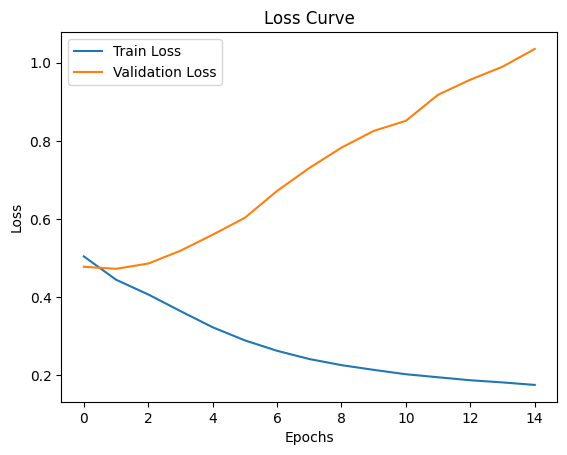

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


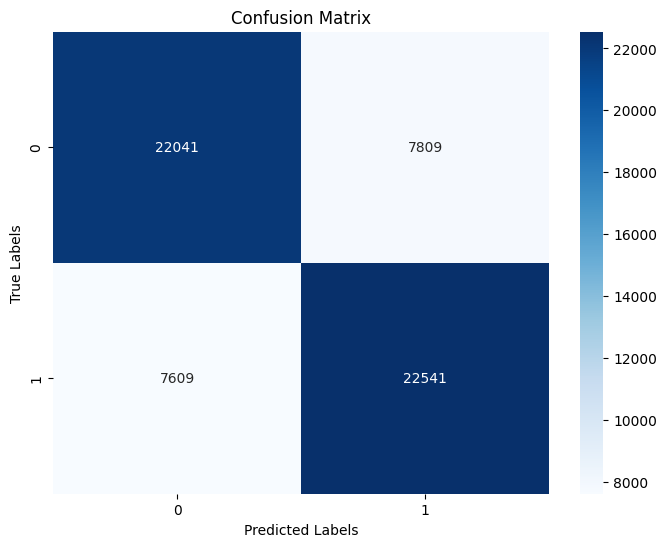

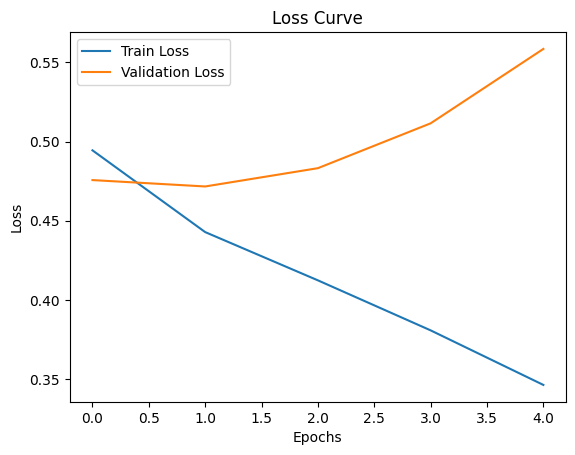

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


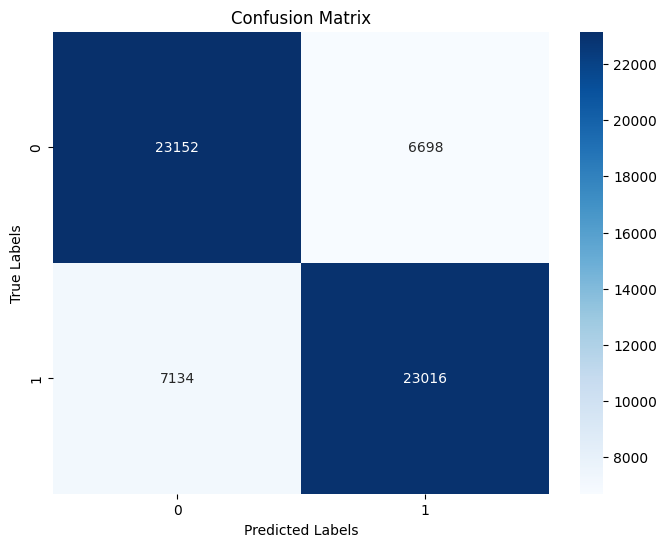

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def draw_loss_curve(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # 绘制训练和验证的 loss 下降曲线
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')

    # 添加图例、标题和标签
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 显示图形
    plt.show()
    
def draw_conf_matrix(y_pre,y_test):
    y_pre_classes = (y_pre> 0.5).astype("int32")
    conf_matrix = confusion_matrix(y_test, y_pre_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    # 添加标题和标签
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # 显示图像
    plt.show()
    
def eva(model,history,X_test,y_test):
    # draw loss curve
    draw_loss_curve(model.history)
    # draw confusion matrix
    y_pre=model.predict(X_test)
    draw_conf_matrix(y_pre,y_test)

models=[[best_cnn_e,history1],[best_lstm_e,history2]]

for model,history in models:
    eva(model,history,X_test,y_test)